In [55]:
# import sys
# sys.path.append('../')
# sys.path.append('/Users/sdbykov/work/my_packages/nway')
# import nway_python_api as nway


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
#set 500 columns for pd
pd.set_option('display.max_columns', 500)

if 'sdbykov' in os.getcwd():
    data_path = '/Users/sdbykov/work/lockman_hole/0_data/'
else:
    data_path = 'data/'

%matplotlib inline

# Viewer functions

In [62]:
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.io import fits
from astropy import units as u
from PIL import Image
import requests
import PIL.ImageOps as pops
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import coordinates

def desi_image_cutout(
    ero_id: str,
    ero_cat: pd.DataFrame, 
    desi_matched: pd.DataFrame,
    csc_matched: pd.DataFrame,
    xmm_matched: pd.DataFrame,
    nway_all_candidates: pd.DataFrame,
    jpeg: bool = True,):
    """
    Return cutout of DESI image around (`ero_ra`, `ero_dec`)
    
    Obtaining Images and Raw Data:
    https://www.legacysurvey.org/dr9/description/


    Parameters
    ----------
    ero_id : str
        id of the eROSITA object
    ero_cat : pd.DataFrame
        eROSITA catalog (with NWAY data)
    desi_matched : pd.DataFrame
        DESI cat matched to eROSITA
    csc_matched : pd.DataFrame
        CSC cat matched to eROSITA
    xmm_matched : pd.DataFrame
        XMM cat matched to eROSITA
    nway_all_candidates : pd.DataFrame
        NWAY data of all candidate counterparts
    jpeg : bool, optional
        If True, plots jpeg image, otherwise fits, by default True

    """

    df_query = ero_cat.query("srcname_fin==@ero_id")
    ero_ra, ero_dec, ero_error = df_query.iloc[0][['RA_fin', 'DEC_fin', 'pos_r98']]

    fits_url = f'https://www.legacysurvey.org/viewer/fits-cutout.fits?ra={ero_ra}&dec={ero_dec}&layer=ls-dr9&pixscale=0.2&bands=grz'
    jpeg_url = f'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ero_ra}&dec={ero_dec}&layer=ls-dr9&pixscale=0.2&bands=grz'
    browser_url = f"https://www.legacysurvey.org/viewer/?ra={ero_ra}&dec={ero_dec}&zoom=16"

    print(f"eROSITA ID: {ero_id}")
    print(f"Browser URL: {browser_url}")

    hdu = fits.open(fits_url)[0]

    # Image dimensions
    wcs = WCS(hdu.header)[0, :, :]
    fits_image_data = hdu.data[0, :, :]

    search_rad = 1.5 * ero_error 
    csc_around = csc_matched.query("srcname_fin	== @ero_id & sep<@search_rad")
    xmm_around = xmm_matched.query("srcname_fin	== @ero_id & Separation<@search_rad")
    desi_around = desi_matched.query("srcname_fin == @ero_id & desi_sep<@search_rad")
    desi_around_extended = desi_around.query('desi_type!="PSF"')


    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(projection=wcs)

    # Color map etc.
    ax.imshow(fits_image_data, cmap='gray_r', origin='lower')
    
    if jpeg:
        jpeg_image = pops.invert(Image.open(requests.get(jpeg_url, stream=True).raw))
        ax.imshow(jpeg_image)

    # Circle for ERO source
    ero_r = SphericalCircle(
        (ero_ra * u.deg, ero_dec * u.deg), ero_error * u.arcsec,
        edgecolor='k', facecolor='none', lw=1,
        transform=ax.get_transform('icrs')
        )
    ax.add_patch(ero_r)

    xlim_frozen = ax.get_xlim()
    ylim_frozen = ax.get_ylim()

    # DESI sources
    ax.scatter(
        desi_around['desi_ra'], desi_around['desi_dec'],
        transform=ax.get_transform('icrs'),
        s=300, edgecolor='blue', facecolor='none',
        lw=.5
        )

    ax.scatter(
        desi_around['desi_ra'], desi_around['desi_dec'],
        transform=ax.get_transform('icrs'),
        s=5, color='blue'
        )
    
    # Extended DESI sources
    ax.scatter(
        desi_around_extended['desi_ra'], desi_around_extended['desi_dec'],
        transform=ax.get_transform('icrs'), marker='D',
        s=300, edgecolor='blue', facecolor='none',
        label='DESI extended', linewidth=.5
        )

    ax.scatter(
        ero_ra, ero_dec,
        transform=ax.get_transform('icrs'),
        s=300, marker='x', color='k', label='ERO'
        )

    #NWAY information
    #nway_cols = nway_desi_id	nway_desi_id_true_ctp nway_prob_has_match	nway_prob_this_match nway_nnmag_grzw1w2	nway_nnmag_grzw1	nway_nnmag_grz
    tmp_df = nway_all_candidates.query("srcname_fin==@ero_id")
    p_any = tmp_df['nway_prob_has_match'].values[0]
    text_total = ''
    for _, row in desi_around.iterrows():
        desi_id = row['desi_desi_id']
        tmp_df_desi = tmp_df.query("nway_desi_id==@desi_id")
        p_i = tmp_df_desi['nway_prob_this_match'].values[0]
        nnmag_grzw1w2 = tmp_df_desi['nway_nnmag_grzw1w2'].values[0]
        nnmag_grzw1 = tmp_df_desi['nway_nnmag_grzw1'].values[0]
        nnmag_grz = tmp_df_desi['nway_nnmag_grz'].values[0]
        if nnmag_grzw1w2!=-99:
            text = f'p_i={p_i:.2f} (nnmag grzw1w2: {nnmag_grzw1w2:.2f})'
        elif nnmag_grzw1!=-99:
            text = f'p_i={p_i:.2f} (nnmag grzw1: {nnmag_grzw1:.2f})'
        elif nnmag_grz!=-99:
            text = f'p_i={p_i:.2f} (nnmag grz: {nnmag_grz:.2f})'
        else:
            text = f'p_i={p_i:.2f} (no nnmag)'
        text_plot = str(tmp_df_desi.desi_objid.values[0])+'|'+ text
        ax.text(row['desi_ra'], row['desi_dec'], text_plot, transform=ax.get_transform('icrs'), fontsize=12, color='blue')
        sep = tmp_df_desi.nway_Separation_EROSITA_DESI.values[0]
        text_print = str(desi_id)+'|' + f"{sep:.2f}"+"''" + '|' + text
        print(text_print)
        text_total += text_print + '\n'


    ax.text(0.05, 0.8, text_total, transform=ax.transAxes, fontsize=12, color='blue')
        

    if len(csc_around) > 0:

        ax.scatter(
            csc_around['ra'], csc_around['dec'],
            transform=ax.get_transform('icrs'),
            s=10, color='r', label='CSC'
            )
        
        for _, row in csc_around.iterrows():
            csc_r = SphericalCircle(
                (row['ra'] * u.deg,
                row['dec'] * u.deg),
                row['r_98_csc'] * u.arcsec,
                edgecolor='red', facecolor='none', lw=1,
                transform=ax.get_transform('icrs')
                )
            ax.add_patch(csc_r)
            
            csc_r_false = SphericalCircle(
                (row['ra'] * u.deg,
                row['dec'] * u.deg),
                1.43* u.arcsec,
                edgecolor='red', facecolor='none', lw=1,
                transform=ax.get_transform('icrs'), ls='--'
                )
            ax.add_patch(csc_r_false)
            
    if len(xmm_around) > 0:

        ax.scatter(
            xmm_around['SC_RA'], xmm_around['SC_DEC'],
            transform=ax.get_transform('icrs'),
            s=10, color='g', label='XMM'
            )
        
        for _, row in xmm_around.iterrows():
            xmm_r = SphericalCircle(
                (row['SC_RA'] * u.deg,
                row['SC_DEC'] * u.deg),
                row['xmm_pos_r98'] * u.arcsec,
                edgecolor='green', facecolor='none', lw=1,
                transform=ax.get_transform('icrs')
                )
            ax.add_patch(xmm_r)
    
            xmm_r_false = SphericalCircle(
                (row['SC_RA'] * u.deg,
                row['SC_DEC'] * u.deg),
                1.43 * u.arcsec,
                edgecolor='green', facecolor='none', lw=1,
                transform=ax.get_transform('icrs'), ls='--'
                )
            ax.add_patch(xmm_r_false)
         
    true_ctps_name = ero_cat.query("srcname_fin==@ero_id")['nway_desi_id_true_ctp'].values[0]
    title = f'{ero_id} | p_any={p_any:.2f} | True: {true_ctps_name}'
    
    ax.set_title(title, y=1.1)
    print()
    print(f'{title}')
    print()

    ax.set(xlim=xlim_frozen, ylim=ylim_frozen)
    lgnd = ax.legend(loc='upper right')
    for handle in lgnd.legendHandles:
        handle._sizes = [70]

    # ICRS coordinates
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='gray', ls='dotted')
    overlay[0].set_axislabel('Right Ascension')
    overlay[1].set_axislabel('Declination')



    plt.show()



def cross_match_data_frames(df1: pd.DataFrame, df2: pd.DataFrame, 
                            colname_ra1: str, colname_dec1: str,
                            colname_ra2: str, colname_dec2: str,
                            match_radius: float = 3.0,
                            df_prefix: str = '',
                            closest: bool = False,
                            ):
    """
    cross_match_data_frames cross-matches two dataframes.
    Cross-match two dataframes with astropy
    https://docs.astropy.org/en/stable/api/astropy.coordinates.match_coordinates_sky.html#astropy.coordinates.match_coordinates_sky
    https://docs.astropy.org/en/stable/api/astropy.coordinates.search_around_sky.html#astropy.coordinates.search_around_sky
    Args:
        df1 (pd.DataFrame): first catalog
        df2 (pd.DataFrame): second catalog
        colname_ra1 (str): columns name for ra in df1
        colname_dec1 (str): columns name for dec in df1
        colname_ra2 (str): columns name for ra in df2
        colname_dec2 (str): columns name for dec in df2
        match_radius (float, optional): match radius in arcsec. Defaults to 3.0.
        df_prefix (str, optional): prefix to prepend to the columns of the second data frame. Defaults to ''. If exists, '_' is appended.
        closest (bool, optional): whether to return the closest match. Defaults to False.

    Returns:
        pd.DataFrame: match of df1 and df2

        the columns are from the original df1 and df2 (with the prefix for df2). 
        added columns: 
        sep - separation in arcsec
        
        n_near - number of matches from df2  for a particular source from df1. For example n_near=10 for a source in df1 means that there are 10 sources  in df2 within the match_radius.

        n_matches - for a given source from df2, this is a number of sources from df1 that are within match_radius. For example n_matches = 2 for a source in df2 means that there are 2 sources in df1 which have this source from df2 within match_radius. If n_matches = 1 then this source from df2 is unique.


    example:
    cross_match_data_frames(desi, gaia, 
                                colname_ra1='RA_fin',
                                colname_dec1='DEC_fin',
                                colname_ra2='ra',
                                colname_dec2='dec',
                                match_radius = 10,
                                df_prefix = 'GAIA',
                                closest=False)
    """
    if df_prefix != '':
        df_prefix = df_prefix + '_'
    else:
        df_prefix = ''

    df1 = df1.copy()
    df2 = df2.copy()

    orig_size_1 = df1.shape[0]
    orig_size_2 = df2.shape[0]

    df1.reset_index(inplace=True)
    df2.reset_index(inplace=True)
    df1.rename(columns={'index': 'index_primary'}, inplace=True)
    df2.rename(columns={'index': 'index_secondary'}, inplace=True)


    coords1 = SkyCoord(ra = df1[colname_ra1].values*u.degree, dec = df1[colname_dec1].values*u.degree)
    coords2 = SkyCoord(ra = df2[colname_ra2].values*u.degree, dec = df2[colname_dec2].values*u.degree)

    idx1, idx2, ang_sep, _ = coordinates.search_around_sky(coords1, coords2, match_radius*u.arcsec)
    ang_sep = ang_sep.to(u.arcsec)
    ang_sep = pd.DataFrame({df_prefix+'sep': ang_sep})

    df1 = df1.loc[idx1]
    df2 = df2.loc[idx2]

    df1.reset_index(inplace = True, drop = True)
    df2.reset_index(inplace = True, drop = True)


    df2.columns  = [df_prefix+x for x in df2.columns]
    df2.rename(columns={df_prefix+'index_secondary':'index_secondary'}, inplace=True)

    df_matched = pd.concat([df1, df2, ang_sep], axis=1) 



    df_matched.sort_values(by=['index_primary', df_prefix+'sep'], inplace=True, ascending=True)

    

    df_matched[df_prefix+'n_near'] = df_matched.groupby('index_primary')[df_prefix+'sep'].transform('count')

    second_index_value_counts = df_matched['index_secondary'].value_counts()
    df_matched[df_prefix+ 'n_matches'] = df_matched['index_secondary'].apply(lambda x: second_index_value_counts[x])


    print('cross-match radius', match_radius, 'arcsec')
    print('total matches:', len(df_matched), 'out of', orig_size_1, 'x' ,orig_size_2)

    print('\t total unique pairs:', len(df_matched.query(df_prefix+'n_matches == 1')))
    
    print('\t total non-unique pairs (duplicates in df2):', len(df_matched.query(df_prefix+'n_matches > 1')))

    if closest:
        df_matched = df_matched.drop_duplicates(subset=['index_primary'], keep='first')
        print('total closest matches:', len(df_matched))

    df_matched.drop(columns=['index_primary'], inplace=True)
    df_matched.drop(columns=['index_secondary'], inplace=True)

    return df_matched                  


In [58]:
erosita = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.gz_pkl', compression='gzip')
erosita_all = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates.gz_pkl', compression='gzip')



desi =  pd.read_pickle(data_path+'desi_lh.gz_pkl', compression = 'gzip')
desi_matched = cross_match_data_frames(erosita[['srcname_fin', 'RA_fin', 'DEC_fin']], desi, 'RA_fin', 'DEC_fin', 'ra', 'dec', 30, df_prefix='desi')

xmm_matched = pd.read_pickle(data_path+'xmm_cleared.pkl')

csc = pd.read_pickle(data_path+'csc_cleared.pkl')
csc_matched = cross_match_data_frames(erosita, csc, 'RA_fin', 'DEC_fin', 'ra', 'dec', 30)

ctps = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
ctps.ID = ctps.ID.str.decode('utf-8')
ctps.desi_id_true_ctp = ctps.desi_id_true_ctp.str.decode('utf-8')


cross-match radius 30 arcsec
total matches: 135854 out of 9215 x 2418574
	 total unique pairs: 131150
	 total non-unique pairs (duplicates in df2): 4704
cross-match radius 30 arcsec
total matches: 739 out of 9215 x 267265
	 total unique pairs: 692
	 total non-unique pairs (duplicates in df2): 47


eROSITA ID: SRGe J103118.8+574434
Browser URL: https://www.legacysurvey.org/viewer/?ra=157.8284537310577&dec=57.74279720695674&zoom=16


9011_610714_1908|0.99''|p_i=0.99 (nnmag grzw1w2: 0.92)
9011_610714_1891|4.59''|p_i=0.01 (no nnmag)

SRGe J103118.8+574434 | p_any=0.98 | True: nan



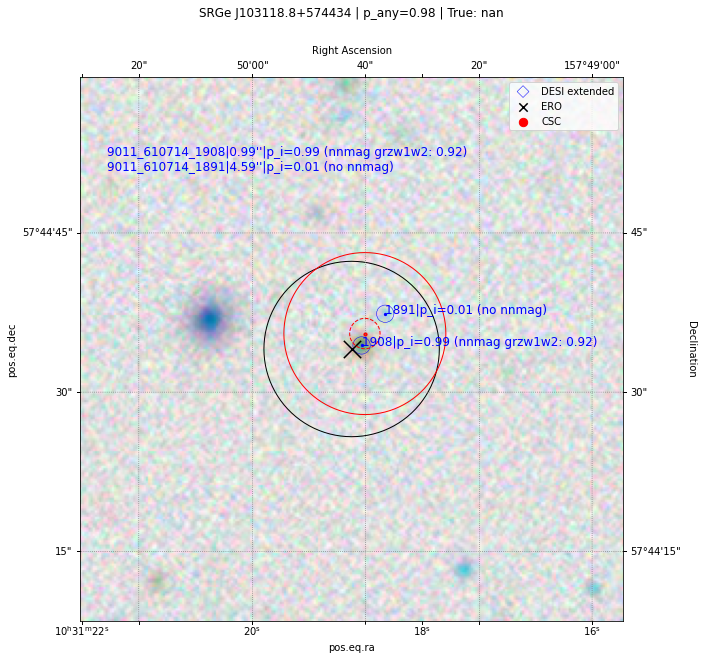

eROSITA ID: SRGe J104656.6+572859
Browser URL: https://www.legacysurvey.org/viewer/?ra=161.73577727668095&dec=57.48298877340159&zoom=16


9011_609947_2233|6.85''|p_i=0.10 (nnmag grzw1w2: 0.45)
9011_609947_2169|7.36''|p_i=0.90 (nnmag grzw1w2: 0.93)

SRGe J104656.6+572859 | p_any=0.02 | True: hostless



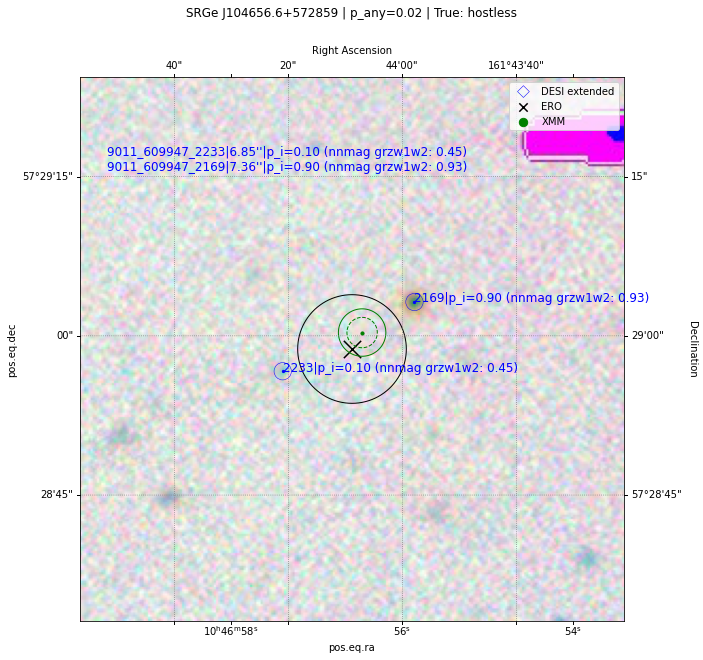

eROSITA ID: SRGe J105137.1+573753
Browser URL: https://www.legacysurvey.org/viewer/?ra=162.90472237077387&dec=57.6312890630485&zoom=16


9011_610725_1347|2.14''|p_i=0.98 (nnmag grzw1w2: 0.92)
9011_610725_1359|2.27''|p_i=0.01 (nnmag grzw1: 0.10)
9011_610725_1340|2.82''|p_i=0.01 (no nnmag)
9011_610725_1353|5.31''|p_i=0.00 (no nnmag)
9011_610725_1368|6.68''|p_i=0.00 (nnmag grzw1w2: 0.34)

SRGe J105137.1+573753 | p_any=0.98 | True: hostless



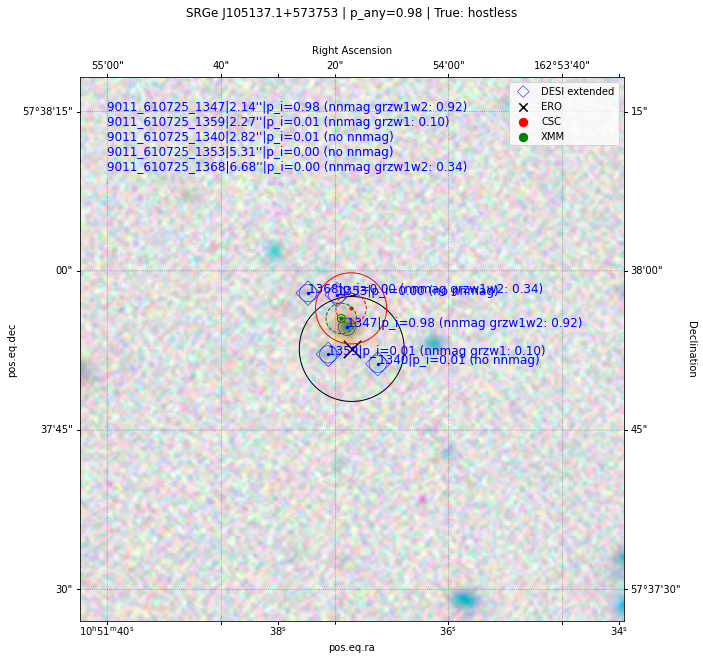

In [63]:
desi_plot = lambda  eroid: desi_image_cutout(eroid,
                ero_cat=erosita,
                desi_matched=desi_matched,
                csc_matched=csc_matched,
                xmm_matched=xmm_matched,
                nway_all_candidates=erosita_all)
                
desi_plot('SRGe J103118.8+574434')
desi_plot('SRGe J104656.6+572859')
desi_plot('SRGe J105137.1+573753')